In [12]:
#move back to the root directory
import os
os.chdir('..')

In [13]:
!pwd

/Users/charlesc/Documents/GitHub/ERP_tools


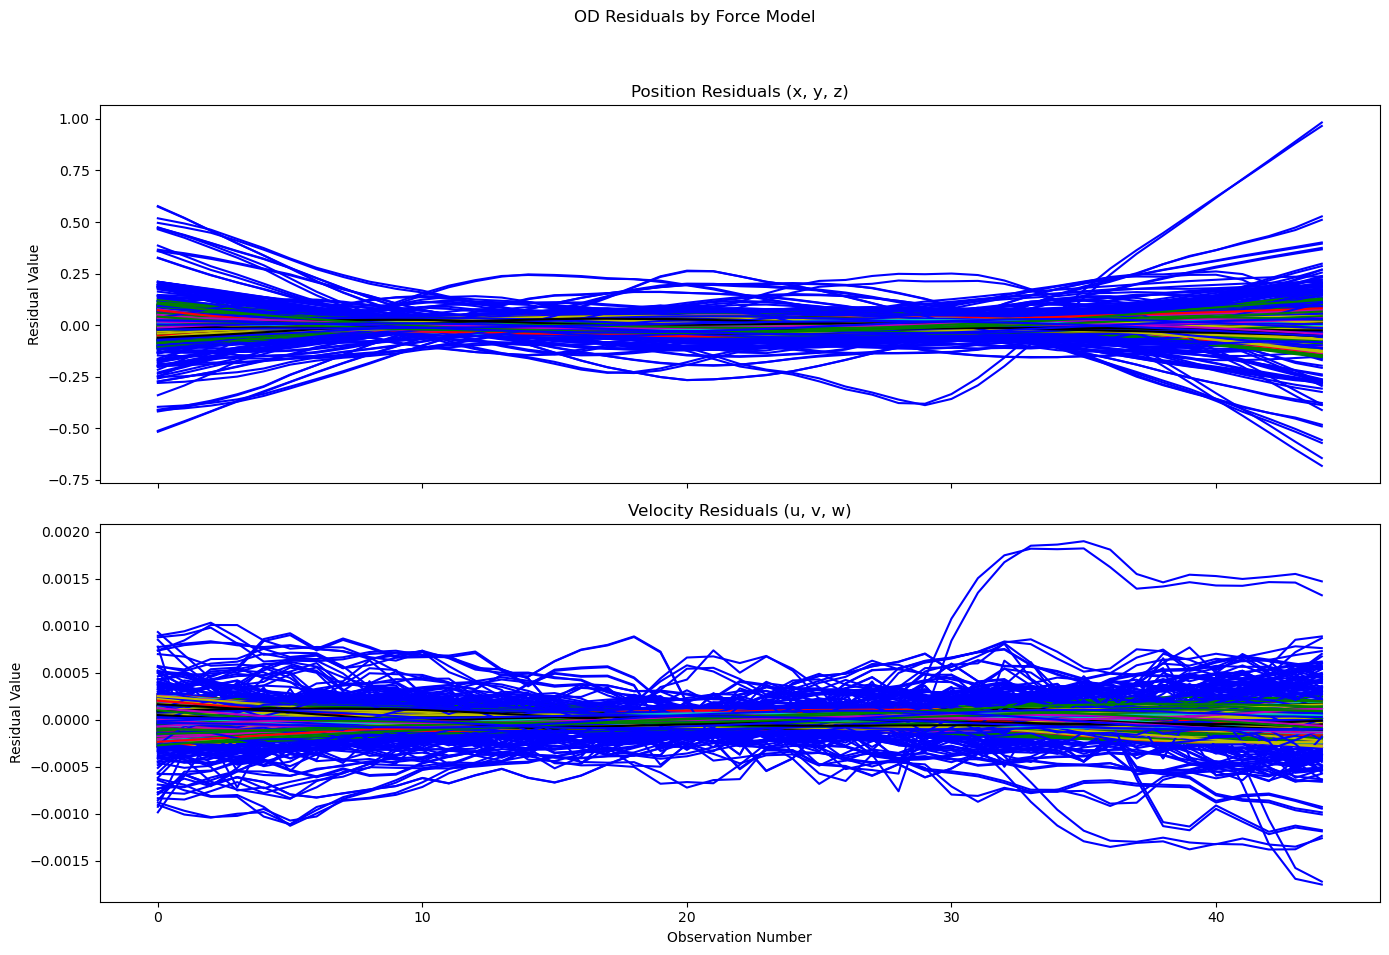

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Base folder path and satellites to test
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]

# Prepare the plot
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle('OD Residuals by Force Model')

# Define colors and labels for the plot
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
position_labels = ['x', 'y', 'z']
velocity_labels = ['u', 'v', 'w']

# Function to extract force model number from directory name
def extract_fm_number(dir_name):
    match = re.search(r'fm(\d+)', dir_name)
    if match:
        return int(match.group(1))
    else:
        return None

# Loop through each satellite and its subdirectories to find and plot OD residuals
for sat_name in sat_names_to_test:
    sat_folder_path = os.path.join(base_folder_path, sat_name)
    
    # Walk through the satellite's directory to find all RMSs.npy and corresponding ODresiduals.npy files
    for root, dirs, files in os.walk(sat_folder_path):
        if 'RMSs.npy' in files:
            fmodel_number = extract_fm_number(root)
            if fmodel_number is not None:
                color = colors[(fmodel_number - 1) % len(colors)]
                label = f'FM {fmodel_number}'
                
                # Load RMS and OD residuals
                RMSs_path = os.path.join(root, 'RMSs.npy')
                residuals_path = os.path.join(root, 'ODresiduals.npy')
                
                RMSs = np.load(RMSs_path)
                od_residuals = np.load(residuals_path)
                min_RMS_index = np.argmin(RMSs)
                selected_residuals = od_residuals[min_RMS_index]

                # Plot position residuals
                for i, label in enumerate(position_labels):
                    axs[0].plot(selected_residuals[:, i], label=f'{label} {fmodel_number}', color=color)
                
                # Plot velocity residuals
                for i, label in enumerate(velocity_labels, start=3):
                    axs[1].plot(selected_residuals[:, i], label=f'{label} {fmodel_number}', color=color)

# Configure subplots and legends
axs[0].set_title('Position Residuals (x, y, z)')
axs[1].set_title('Velocity Residuals (u, v, w)')
axs[1].set_xlabel('Observation Number')
axs[0].set_ylabel('Residual Value')
axs[1].set_ylabel('Residual Value')
# axs[0].legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
# axs[1].legend(title='Velocity', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from matplotlib import patheffects

# Base folder path and satellites
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]

# Function to parse details from the folder name
def parse_folder_details(folder_name):
    fm_match = re.search(r'fm(\d+)', folder_name)
    arc_match = re.search(r'arc(\d+)', folder_name)
    fm = int(fm_match.group(1)) if fm_match else None
    arc = int(arc_match.group(1)) if arc_match else None
    return fm, arc

# Initialize list for data
improvements_data = []

# Process directories
for sat_name in sat_names_to_test:
    rms_values = {}  # (force_model, arc) : RMS

    for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
        for file in files:
            if file == 'RMSs.npy':
                fm, arc = parse_folder_details(root)
                if fm and arc:
                    rms_path = os.path.join(root, file)
                    rms = np.min(np.load(rms_path))
                    rms_values[(fm, arc)] = rms

    sorted_keys = sorted(rms_values.keys(), key=lambda x: (x[1], x[0]))  # Sort by arc, then by FM for correct sequential processing
    for i in range(1, len(sorted_keys)):
        prev_key, curr_key = sorted_keys[i-1], sorted_keys[i]
        # Ensure the comparison is for the same arc and consecutive force models
        if prev_key[1] == curr_key[1] and curr_key[0] == prev_key[0] + 1:
            prev_rms, curr_rms = rms_values[prev_key], rms_values[curr_key]
            improvement = (prev_rms - curr_rms) / prev_rms * 100
            improvements_data.append({
                'Satellite': sat_name,
                'Force_Model_Transition': f'FM{prev_key[0]} to FM{curr_key[0]}',
                'Improvement': improvement
            })

# Create DataFrame
df_improvements = pd.DataFrame(improvements_data)

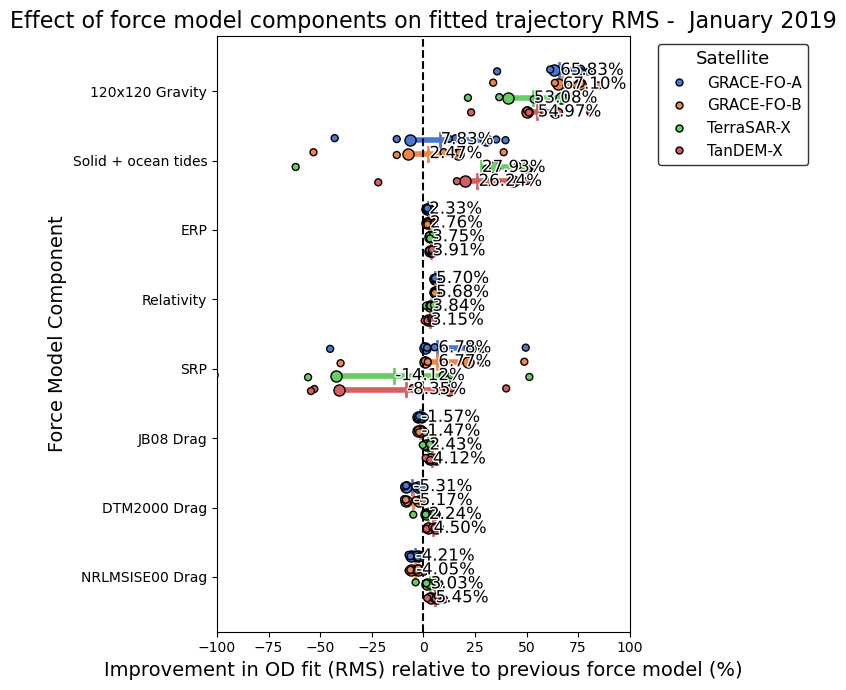

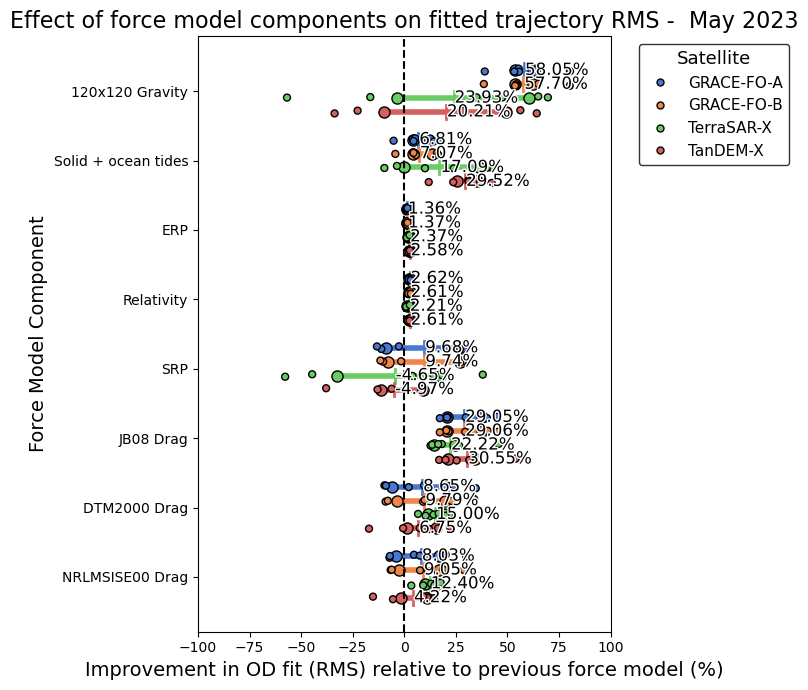

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from matplotlib import patheffects

base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]

force_model_steps = [
    {'36x36 Gravity+3BP': True},
    {'120x120 Gravity': True},
    {'Solid + ocean tides': True},
    {'ERP': True},
    {'Relativity': True},
    {'SRP': True},
    {'JB08 Drag': True},
    {'DTM2000 Drag': True},
    {'NRLMSISE00 Drag': True}
]

def parse_folder_details(folder_name):
    fm_match = re.search(r'fm(\d+)', folder_name)
    arc_match = re.search(r'arc(\d+)', folder_name)
    date_match = re.search(r'_(\d{4})-\d{2}-\d{2}', folder_name)
    fm = int(fm_match.group(1)) if fm_match else None
    arc = int(arc_match.group(1)) if arc_match else None
    year = int(date_match.group(1)) if date_match else None
    return fm, arc, year

rms_values = {}
for sat_name in sat_names_to_test:
    sat_folder = os.path.join(base_folder_path, sat_name)
    for root, dirs, files in os.walk(sat_folder):
        for file in files:
            if file.endswith('RMSs.npy'):
                fm, arc, year = parse_folder_details(root)
                if year not in rms_values:
                    rms_values[year] = {}
                rms = np.load(os.path.join(root, file)).min()
                rms_values[year][(sat_name, arc, fm)] = rms

def plot_data(years, title_suffix):
    combined_improvements_data = []
    for year in years:
        improvements_data = []
        for sat_name in sat_names_to_test:
            for arc in set(key[1] for key in rms_values[year] if key[0] == sat_name):
                base_rms = None
                for fm in range(1, 10):
                    key = (sat_name, arc, fm)
                    if key in rms_values[year]:
                        if fm <= 6:
                            base_rms = rms_values[year][key]
                        improvement = 0
                        if fm == 1:
                            continue
                        elif fm <= 6:
                            prev_key = (sat_name, arc, fm-1)
                            improvement = (rms_values[year][prev_key] - rms_values[year][key]) / rms_values[year][prev_key] * 100
                        else:
                            improvement = (base_rms - rms_values[year][key]) / base_rms * 100
                        improvements_data.append({
                            'Satellite': sat_name,
                            'Force_Model_Transition': f'FM{fm-1} to FM{fm}' if fm <= 6 else f'FM6 to FM{fm}',
                            'Improvement': improvement,
                            'Year': year  # Include year for filtering
                        })
        combined_improvements_data += improvements_data

    df_improvements = pd.DataFrame(combined_improvements_data)
    if not df_improvements.empty:
        df_improvements['Component_Added'] = df_improvements['Force_Model_Transition'].apply(lambda transition: list(force_model_steps[int(transition.split(' to ')[1].replace('FM', ''))-1].keys())[0])

        plt.figure(figsize=(8, 7))
        palette = sns.color_palette("muted", len(pd.unique(df_improvements['Satellite'])))
        stripplot = sns.stripplot(data=df_improvements, x='Improvement', y='Component_Added', hue='Satellite', dodge=True, palette=palette, edgecolor='black', linewidth=1)

        handles, labels = stripplot.get_legend_handles_labels()
        plt.legend(handles, labels, title='Satellite', bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor='black', title_fontsize='13', fontsize='11', labelcolor='black')

        dodge_width = 0.2
        for component in pd.unique(df_improvements['Component_Added']):
            for i, satellite in enumerate(pd.unique(df_improvements['Satellite'])):
                subset = df_improvements[(df_improvements['Component_Added'] == component) & (df_improvements['Satellite'] == satellite)]
                if not subset.empty:
                    mean_value = subset['Improvement'].mean()
                    q1 = subset['Improvement'].quantile(0.25)
                    q3 = subset['Improvement'].quantile(0.75)
                    y_position = list(pd.unique(df_improvements['Component_Added'])).index(component)
                    y_adjusted = y_position + (i - (len(pd.unique(df_improvements['Satellite']))-1)/2) * dodge_width

                    plt.plot([mean_value, mean_value], [y_adjusted - dodge_width/2, y_adjusted + dodge_width/2], color=palette[i], lw=2)
                    plt.plot([q1, q3], [y_adjusted, y_adjusted], color=palette[i], lw=4, marker='o', markersize=8, markeredgecolor='black')

                    text_x = mean_value + 0.5
                    plt.text(text_x, y_adjusted, f'{mean_value:.2f}%', color='black', va='center', fontsize=12, path_effects=[patheffects.withStroke(linewidth=2, foreground="white")])

        plt.title(f'Effect of force model components on fitted trajectory RMS - {title_suffix}', color='black', fontsize=16)
        plt.xlabel('Improvement in OD fit (RMS) relative to previous force model (%)', color='black', fontsize=14)
        plt.ylabel('Force Model Component', color='black', fontsize=14)
        plt.xticks(color='black')
        plt.yticks(color='black')
        plt.axvline(0, color='black', linestyle='--')
        #force x-axis to go from -100 to 100
        plt.xlim(-100,100)
        plt.tight_layout()
        plt.show()

# Plot for 2018-2019
plot_data([
    
    
 2019], " January 2019")
# Plot for 2023
plot_data([2023], " May 2023")


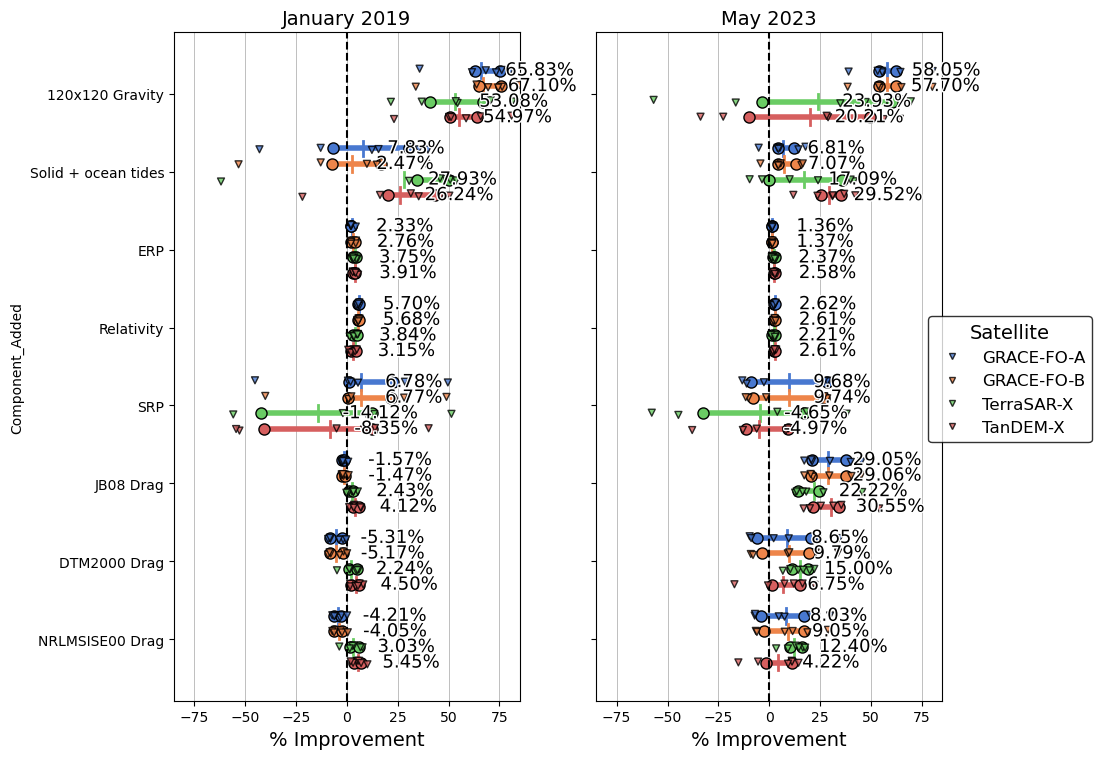

In [29]:
def plot_data_side_by_side(years, title_suffixes):
    fig, axes = plt.subplots(1, len(years), figsize=(10, 7.7), sharey=True)  # Share y-axis across subplots
    if len(years) == 1:  # If only one year is passed, wrap axes in a list for consistent indexing
        axes = [axes]
    
    for year_index, year in enumerate(years):
        ax = axes[year_index]  # Current axis for plotting
        improvements_data = []
        for sat_name in sat_names_to_test:
            for arc in set(key[1] for key in rms_values[year] if key[0] == sat_name):
                base_rms = None
                for fm in range(1, 10):
                    key = (sat_name, arc, fm)
                    if key in rms_values[year]:
                        if fm <= 6:
                            base_rms = rms_values[year][key]
                        improvement = 0
                        if fm == 1:
                            continue
                        elif fm <= 6:
                            prev_key = (sat_name, arc, fm-1)
                            improvement = (rms_values[year][prev_key] - rms_values[year][key]) / rms_values[year][prev_key] * 100
                        else:
                            improvement = (base_rms - rms_values[year][key]) / base_rms * 100
                        improvements_data.append({
                            'Satellite': sat_name,
                            'Force_Model_Transition': f'FM{fm-1} to FM{fm}' if fm <= 6 else f'FM6 to FM{fm}',
                            'Improvement': improvement,
                            'Year': year  # Include year for filtering
                        })

        df_improvements = pd.DataFrame(improvements_data)
        if not df_improvements.empty:
            df_improvements['Component_Added'] = df_improvements['Force_Model_Transition'].apply(lambda transition: list(force_model_steps[int(transition.split(' to ')[1].replace('FM', ''))-1].keys())[0])
            palette = sns.color_palette("muted", len(pd.unique(df_improvements['Satellite'])))
            sns.stripplot(ax=ax, data=df_improvements, x='Improvement', y='Component_Added', hue='Satellite', dodge=True, palette=palette, edgecolor='black', linewidth=1, alpha=0.8, marker='v')

            dodge_width = 0.2
            for component in pd.unique(df_improvements['Component_Added']):
                for i, satellite in enumerate(pd.unique(df_improvements['Satellite'])):
                    subset = df_improvements[(df_improvements['Component_Added'] == component) & (df_improvements['Satellite'] == satellite)]
                    if not subset.empty:
                        mean_value = subset['Improvement'].mean()
                        q1 = subset['Improvement'].quantile(0.25)
                        q3 = subset['Improvement'].quantile(0.75)
                        y_position = list(pd.unique(df_improvements['Component_Added'])).index(component)
                        y_adjusted = y_position + (i - (len(pd.unique(df_improvements['Satellite']))-1)/2) * dodge_width

                        ax.plot([mean_value, mean_value], [y_adjusted - dodge_width/2, y_adjusted + dodge_width/2], color=palette[i], lw=2)
                        ax.plot([q1, q3], [y_adjusted, y_adjusted], color=palette[i], lw=4, marker='o', markersize=8, markeredgecolor='black')

                        text_x = mean_value + 12  # Adjust text position based on value
                        ax.text(text_x, y_adjusted, f'{mean_value:.2f}%', color='black', va='center', fontsize=13, path_effects=[patheffects.withStroke(linewidth=2, foreground="white")])

            ax.set_title(f'{title_suffixes[year_index]}', color='black', fontsize=14)
            ax.set_xlabel('% Improvement', color='black', fontsize=14)
            ax.tick_params(colors='black')
            ax.axvline(0, color='black', linestyle='--')
            ax.set_xlim(-85, 85)

    # Place the legend outside the last subplot
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title='Satellite', bbox_to_anchor=(0.925, 0.5), loc='center left', edgecolor='black', title_fontsize='14', fontsize='12', labelcolor='black')
    # Remove legends from individual plots to avoid duplication
    for ax in axes:
        ax.get_legend().remove()
        ax.grid(which='major', axis='x', linestyle='-', linewidth=0.5, color='grey', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot for 2019 and 2023 side by side with updated requirements
plot_data_side_by_side([2019, 2023], ["January 2019", "May 2023"])


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def calculate_differences(years):
    combined_improvements_data = []
    for year in years:
        improvements_data = []
        for sat_name in sat_names_to_test:
            for arc in set(key[1] for key in rms_values[year] if key[0] == sat_name):
                print(f"arc{arc}")
                base_rms = None
                for fm in range(1, 10):
                    key = (sat_name, arc, fm)
                    if key in rms_values[year]:
                        if fm <= 6:
                            base_rms = rms_values[year][key]
                        improvement = 0
                        if fm == 1:
                            continue
                        elif fm <= 6:
                            prev_key = (sat_name, arc, fm-1)
                            improvement = (rms_values[year][prev_key] - rms_values[year][key]) / rms_values[year][prev_key] * 100
                        else:
                            improvement = (base_rms - rms_values[year][key]) / base_rms * 100
                        improvements_data.append({
                            'Satellite': sat_name,
                            'Force_Model_Transition': f'FM{fm-1} to FM{fm}' if fm <= 6 else f'FM6 to FM{fm}',
                            'Improvement': improvement,
                            'Year': year  # Include year for filtering
                        })
        combined_improvements_data += improvements_data
    
    df_improvements = pd.DataFrame(combined_improvements_data)
    if not df_improvements.empty:
        df_improvements['Component_Added'] = df_improvements['Force_Model_Transition'].apply(
            lambda transition: list(force_model_steps[int(transition.split(' to ')[1].replace('FM', ''))-1].keys())[0])
        
    return df_improvements

# Calculate differences between years
df_2019_2023 = calculate_differences([2023, 2019])
# print(f"Data for 2019 and 2023 for TanDEM-X:\n{df_2019_2023[df_2019_2023['Satellite'] == 'TanDEM-X']}\n")

# Calculate the mean improvement for 2019 and 2023, then calculate the difference
mean_improvements = df_2019_2023.groupby(['Satellite', 'Component_Added', 'Year'])['Improvement'].mean().reset_index()
pivot_table = mean_improvements.pivot_table(values='Improvement', index=['Satellite', 'Component_Added'], columns='Year')
pivot_table['Difference'] = pivot_table[2019]- pivot_table[2023]

# Extract component names from force_model_steps in the specified order
force_model_order = [list(fm.keys())[0] for fm in force_model_steps]

pivot_table_reset = pivot_table.reset_index()

# Create an ordering index based on the specified order of force model components
order_index = dict(zip(force_model_order, range(len(force_model_order))))

# Add a temporary ordering column to the DataFrame
pivot_table_reset['Order'] = pivot_table_reset['Component_Added'].map(order_index)

# Sort the DataFrame based on the new ordering column
pivot_table_reset = pivot_table_reset.sort_values(by=['Order'])

unique_satellites = pivot_table_reset['Satellite'].unique()
palette = sns.color_palette("muted", len(unique_satellites))

plt.figure(figsize=(8, 5))

# Positions and width for the bars
n_components = len(pivot_table_reset['Component_Added'].unique())
component_positions = np.arange(n_components)
bar_width = 0.35 / len(unique_satellites)  # Adjusted width for clarity

# Plot bars
for idx, satellite in enumerate(unique_satellites):
    # Filter data for each satellite
    satellite_data = pivot_table_reset[pivot_table_reset['Satellite'] == satellite]
    
    # Determine color
    color = palette[idx]
    
    # Plot 2019 bars
    positions_2019 = component_positions - bar_width/2 + idx*bar_width*2
    plt.bar(positions_2019, satellite_data[2019].values, color=color, width=bar_width, label=f'{satellite} 2019', hatch='//', edgecolor='black')
    
    # Plot 2023 bars next to 2019
    positions_2023 = positions_2019 + bar_width
    plt.bar(positions_2023, satellite_data[2023].values, color=color, width=bar_width, label=f'{satellite} 2023', edgecolor='black')

# Add labels and customize chart
plt.xticks(component_positions, pivot_table_reset['Component_Added'].unique(), rotation=45)

plt.title('Mean Improvement in OD fit form addition of force model component')
plt.ylabel('Improvement (%)')
plt.xlabel('Force Model Component')

# Creating a custom legend to avoid duplicate entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removing duplicates, keeping the last occurrence
plt.legend(by_label.values(), by_label.keys(), title='Satellite & Year', bbox_to_anchor=(1.05, 1), loc='upper left')

#make the grid every 10%
plt.yticks(np.arange(-25, 76, 10))
plt.axhline(0, color='black', linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='black', linewidth=0.7)
plt.tight_layout()
plt.show()

KeyError: 2023

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

# Base folder path and satellite names
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]
components = ['H', 'C', 'L']

# Function to extract and normalize force model configuration, removing arc identifiers
def extract_force_model(config_name):
    normalized_config = re.sub(r'arc\d+_', '', config_name)
    return normalized_config

# Initialize color map and discover unique force models
color_map = {}
unique_force_models = set()

for sat_name in sat_names_to_test:
    for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
        for file in files:
            if file.endswith("_hcl_diffs.npy"):
                hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                for component in components:
                    if component in hcl_diffs:
                        for config in hcl_diffs[component]:
                            force_model = extract_force_model(config)
                            unique_force_models.add(force_model)

sns.set_palette("husl", len(unique_force_models))
for i, model in enumerate(unique_force_models):
    color_map[model] = sns.color_palette()[i]

# Function to simplify force model labels for the legend
def simplify_labels(unique_force_models):
    simplified_labels = {}
    previous_elements = []
    for model in sorted(unique_force_models):
        elements = model.split('+')
        new_elements = [e for e in elements if e not in previous_elements]
        previous_elements.extend(new_elements)
        simplified_labels[model] = '+'.join(new_elements) if new_elements else model
    return simplified_labels

simplified_labels = simplify_labels(unique_force_models)

# Plotting with customized legend
for sat_name in sat_names_to_test:
    for component in components:
        plt.figure(figsize=(8, 6))
        
        legend_labels = {}

        for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
            for file in files:
                if file.endswith("_hcl_diffs.npy"):
                    hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                    if component in hcl_diffs:
                        for config, diffs in hcl_diffs[component].items():
                            force_model = extract_force_model(config)
                            times = np.arange(len(diffs[0]))
                            label = simplified_labels[force_model]
                            scatter = plt.scatter(times, diffs[0], label=label, s=2, color=color_map[force_model])
                            legend_labels[label] = scatter
        
        plt.title(f'{sat_name} - {component} Differences Over Time', color='black')
        plt.xlabel('Time Index', color='black')
        plt.ylabel(f'{component} Difference', color='black')
        plt.tick_params(axis='x', colors='black')
        plt.tick_params(axis='y', colors='black')

        # Update legend
        legend = plt.legend(legend_labels.values(), legend_labels.keys(), loc='best', fontsize='small')
        for text in legend.get_texts():
            text.set_color('black')
        #make the points in the legend larger
        for handle in legend.legendHandles:
            handle.set_sizes([50.0])
        plt.tight_layout()
        plt.show()


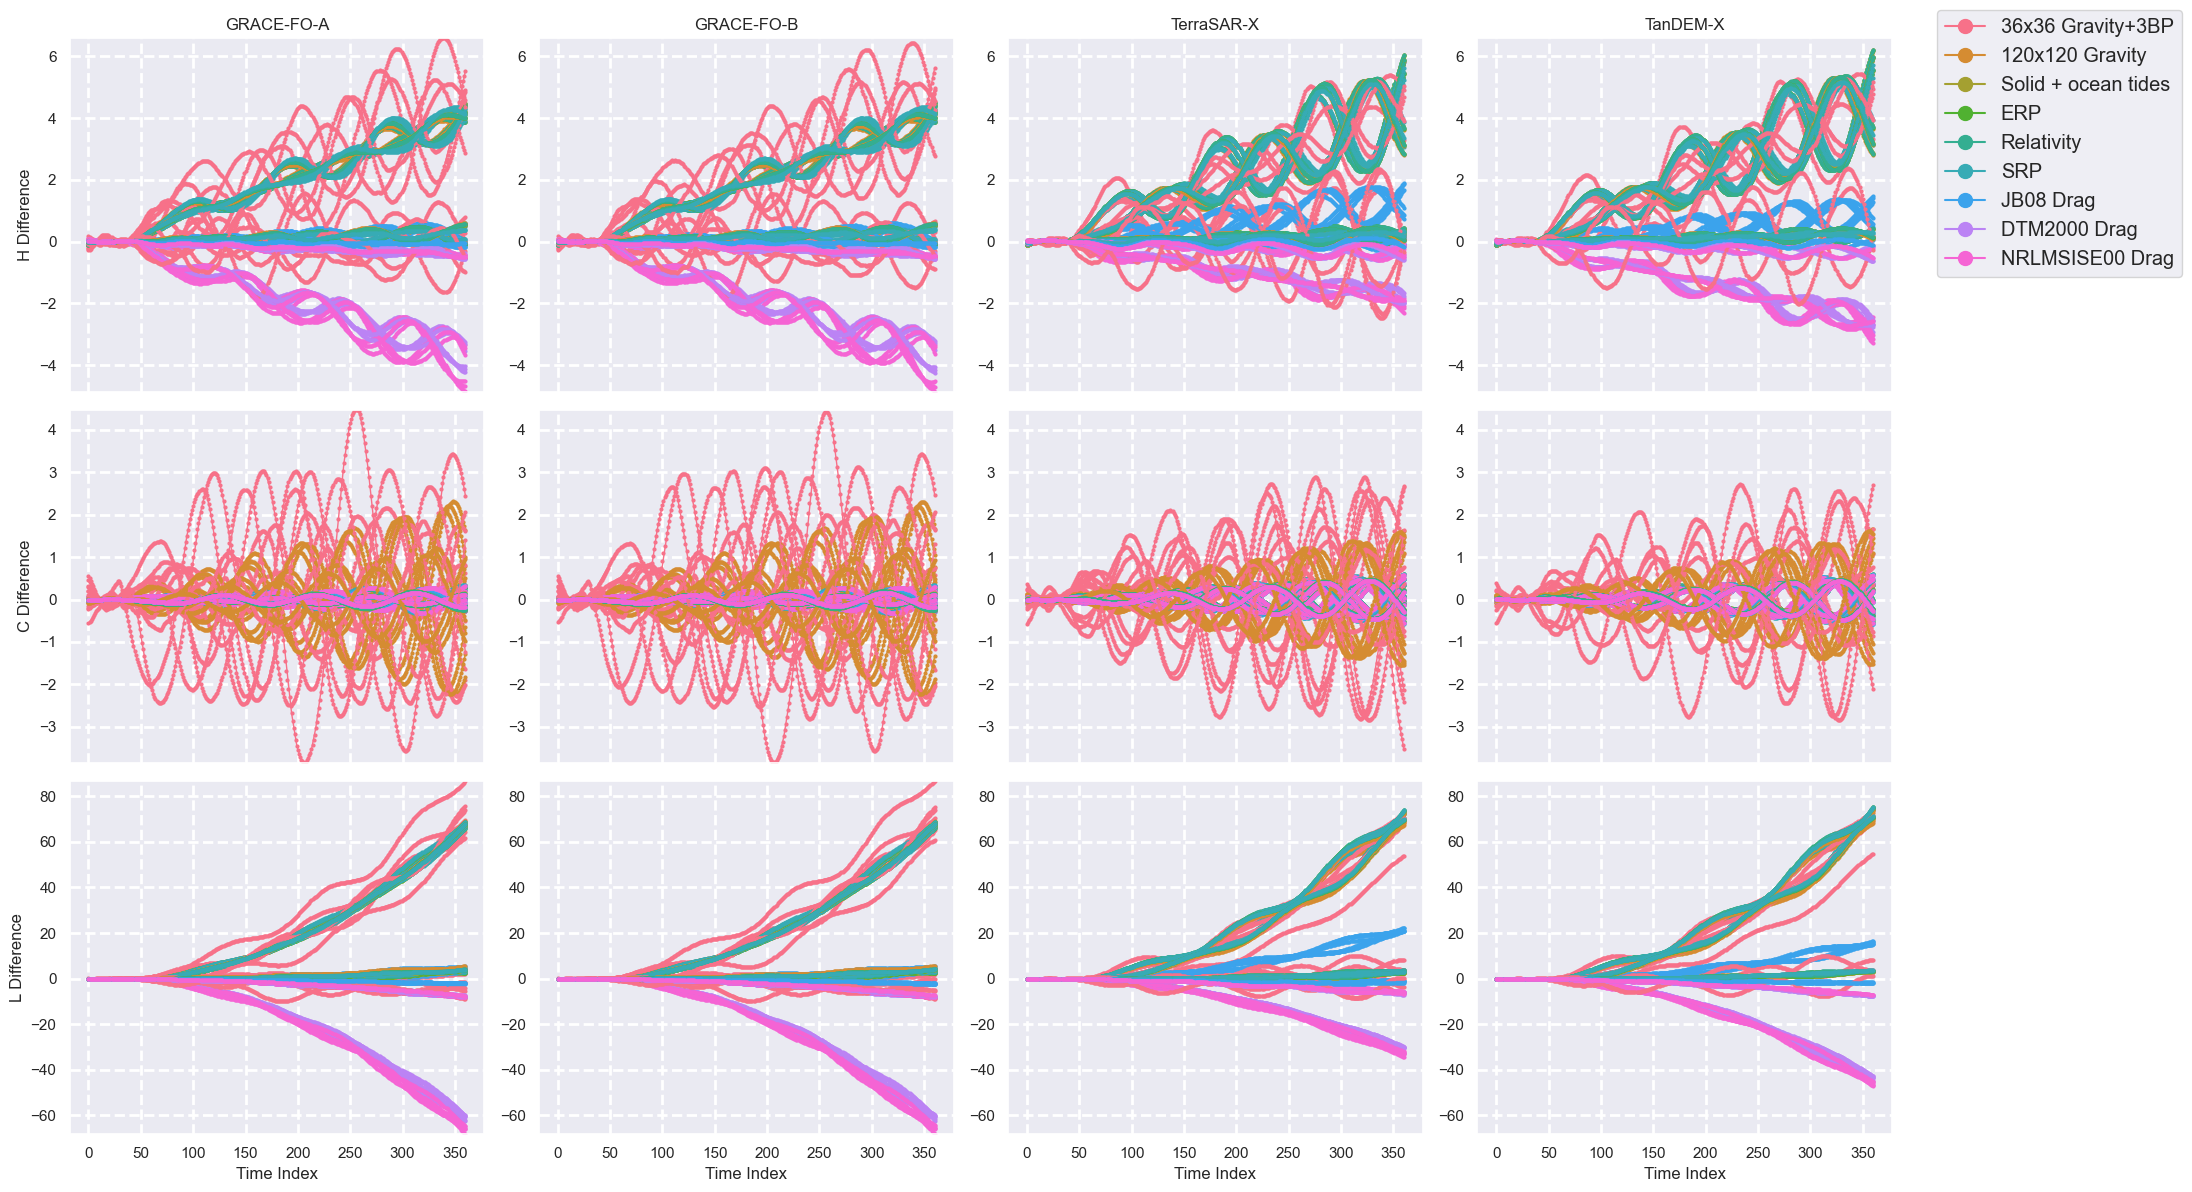

In [464]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

# Base folder path and satellite names
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]
components = ['H', 'C', 'L']

# Function to extract and normalize force model configuration, removing arc identifiers
def extract_force_model(config_name):
    normalized_config = re.sub(r'arc\d+_', '', config_name)
    return normalized_config

# Initialize color map and discover unique force models
color_map = {}
unique_force_models = set()

for sat_name in sat_names_to_test:
    for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
        for file in files:
            if file.endswith("_hcl_diffs.npy"):
                hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                for component in hcl_diffs:
                    if component in hcl_diffs:
                        for config in hcl_diffs[component]:
                            force_model = extract_force_model(config)
                            unique_force_models.add(force_model)

# Define your specific color map based on force_model_steps
force_model_steps = [
    '36x36 Gravity+3BP',
    '120x120 Gravity',
    'Solid + ocean tides',
    'ERP',
    'Relativity',
    'SRP',
    'JB08 Drag',
    'DTM2000 Drag',
    'NRLMSISE00 Drag'
]

# Assign colors from a palette to your force_model_steps
sns.set_palette("husl", len(force_model_steps))
color_map = {model: color for model, color in zip(force_model_steps, sns.color_palette())}

# Create a subplot grid
fig, axs = plt.subplots(len(components), len(sat_names_to_test), figsize=(5*len(sat_names_to_test), 4*len(components)), sharex=True)

y_min_max_per_row = {row: [np.inf, -np.inf] for row in range(len(components))}

for col_idx, sat_name in enumerate(sat_names_to_test):
    for row_idx, component in enumerate(components):
        ax = axs[row_idx, col_idx]
        
        for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
            for file in files:
                if file.endswith("_hcl_diffs.npy"):
                    hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                    if component in hcl_diffs:
                        for config, diffs in hcl_diffs[component].items():
                            force_model = extract_force_model(config)
                            times = np.arange(len(diffs[0]))
                            color = color_map.get(force_model)
                            ax.plot(times, diffs[0], label=force_model, color=color, marker='o', markersize=2, linestyle='-', linewidth=1)
                            y_min_max_per_row[row_idx][0] = min(y_min_max_per_row[row_idx][0], min(diffs[0]))
                            y_min_max_per_row[row_idx][1] = max(y_min_max_per_row[row_idx][1], max(diffs[0]))
                        ax.grid(True, which='both', linestyle='--', linewidth=2)

        if row_idx == 0:
            ax.set_title(sat_name)
        if col_idx == 0:
            ax.set_ylabel(f'{component} Difference')
        if row_idx == len(components) - 1:
            ax.set_xlabel('Time Index')

# Apply unified y-axis scale by component across all columns
for row_idx in range(len(components)):
    for col_idx in range(len(sat_names_to_test)):
        axs[row_idx, col_idx].set_ylim(y_min_max_per_row[row_idx])

# Create custom legend handles with correct colors and larger dots
legend_handles = [plt.Line2D([0], [0], marker='o', color=color, label=model, markersize=10, markerfacecolor=color, linestyle='-') for model, color in color_map.items()]

# Place the legend outside the subplot grid
fig.legend(handles=legend_handles, labels=force_model_steps, loc='upper right', bbox_to_anchor=(1.1, 1), fontsize='large')

plt.tight_layout()
plt.subplots_adjust(right=0.95) # Adjust subplot params to make room for legend
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import matplotlib.ticker as ticker

# Base folder path and satellite names
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]
components = ['H', 'C', 'L']

def extract_force_model(config_name):
    return re.sub(r'arc\d+_', '', config_name)

sat_color_map = {}
sns.set_palette("husl", len(sat_names_to_test))
for i, sat_name in enumerate(sat_names_to_test):
    sat_color_map[sat_name] = sns.color_palette()[i]

global_min_max = {component: {'min': float('inf'), 'max': float('-inf')} for component in components}
unique_force_models = set()
for sat_name in sat_names_to_test:
    for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
        for file in files:
            if file.endswith("_hcl_diffs.npy"):
                hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                for component in components:
                    if component in hcl_diffs:
                        for config, diffs in hcl_diffs[component].items():
                            force_model = extract_force_model(config)
                            unique_force_models.add(force_model)
                            global_min_max[component]['min'] = min(global_min_max[component]['min'], np.min(diffs[0]))
                            global_min_max[component]['max'] = max(global_min_max[component]['max'], np.max(diffs[0]))

def simplify_labels(force_models):
    simplified = {}
    all_elements = set()
    for model in force_models:
        elements = model.split('+')
        new_elements = [e for e in elements if e not in all_elements]
        all_elements.update(new_elements)
        simplified[model] = '+'.join(new_elements)
    ordered_labels = [simplified[model] for model in force_models]
    return ordered_labels

sorted_force_models = sorted(unique_force_models)
sorted_force_models = [sorted_force_models[-1]] + [sorted_force_models[0]] + sorted_force_models[1:-1]
simplified_labels = simplify_labels(sorted_force_models)

for component in components:
    fig, axs = plt.subplots(len(sorted_force_models), 1, figsize=(8, 1 * len(sorted_force_models)), sharex=True)
    fig.suptitle(f'{component} Differences', color='black', fontsize=14)
    
    # Re-adjust the order after manual swap if needed
    sorted_force_models[-3], sorted_force_models[-2] = sorted_force_models[-2], sorted_force_models[-3]
    simplified_labels = simplify_labels(sorted_force_models)
    
    if len(sorted_force_models) == 1:
        axs = [axs]
    
    y_min, y_max = global_min_max[component]['min'], global_min_max[component]['max']
    for i, force_model in enumerate(sorted_force_models):
        text_positions = {}  # Track text positions to adjust offset if needed
        for sat_name in sat_names_to_test:
            final_values = []
            for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
                for file in files:
                    if file.endswith("_hcl_diffs.npy"):
                        hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                        if component in hcl_diffs:
                            for config, diffs in hcl_diffs[component].items():
                                if extract_force_model(config) == force_model:
                                    times = np.arange(len(diffs[0]))
                                    final_values.append(diffs[0][-1])
                                    axs[i].plot(times, diffs[0], label=sat_name, color=sat_color_map[sat_name], linewidth=1)
            if final_values:
                mean_final_value = np.mean(final_values)
                # Determine a suitable vertical position for the text
                vertical_position = mean_final_value + (y_max - y_min) * 0.2 * (len(text_positions) + 1)  # Offset each text a bit higher
                # Ensure text is within plot bounds
                if vertical_position > y_max:
                    vertical_position = y_max - (y_max - y_min) * 0.2 * len(text_positions)
                text_positions[sat_name] = vertical_position
                axs[i].text(times[-1], vertical_position, f'{mean_final_value:.2f}',
                            color=sat_color_map[sat_name], fontsize=12, fontweight='bold', verticalalignment='center')
        
        axs[i].set_ylim(y_min, y_max)
        axs[i].set_ylabel(simplified_labels[i], color='black', rotation=0, labelpad=100, fontsize=10)
        axs[i].tick_params(axis='x', colors='black')
        axs[i].tick_params(axis='y', colors='black', which='both')
        axs[i].yaxis.set_major_locator(ticker.MaxNLocator(5))
        axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    
    plt.subplots_adjust(hspace=0, left=0.2)
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=1, frameon=False, fontsize='small', borderaxespad=0.)
    
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import matplotlib.ticker as ticker

# Base folder path and satellite names are defined as before
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]
components = ['H', 'C', 'L']

def extract_force_model(config_name):
    return re.sub(r'arc\d+_', '', config_name)

sat_color_map = {}
sns.set_palette("husl", len(sat_names_to_test))
for i, sat_name in enumerate(sat_names_to_test):
    sat_color_map[sat_name] = sns.color_palette()[i]

global_min_max = {component: {'min': float('inf'), 'max': float('-inf')} for component in components}
unique_force_models = set()

global_min_max = {component: {'min': float('inf'), 'max': float('-inf')} for component in components}
unique_force_models = set()
for sat_name in sat_names_to_test:
    for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
        for file in files:
            if file.endswith("_hcl_diffs.npy"):
                hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                for component in components:
                    if component in hcl_diffs:
                        for config, diffs in hcl_diffs[component].items():
                            force_model = extract_force_model(config)
                            unique_force_models.add(force_model)
                            global_min_max[component]['min'] = min(global_min_max[component]['min'], np.min(diffs[0]))
                            global_min_max[component]['max'] = max(global_min_max[component]['max'], np.max(diffs[0]))

def simplify_labels(force_models):
    simplified = {}
    all_elements = set()
    for model in force_models:
        elements = model.split('+')
        new_elements = [e for e in elements if e not in all_elements]
        all_elements.update(new_elements)
        simplified[model] = '+'.join(new_elements)
    ordered_labels = [simplified[model] for model in force_models]
    return ordered_labels

sorted_force_models = sorted(unique_force_models)
sorted_force_models = [sorted_force_models[-1]] + [sorted_force_models[0]] + sorted_force_models[1:-1]
simplified_labels = simplify_labels(sorted_force_models)

for component in components:
    fig, axs = plt.subplots(len(unique_force_models), 1, figsize=(6, 1 * len(unique_force_models)), sharex=True)
    fig.suptitle(f'{component} Differences', color='black', fontsize=14)

    if len(unique_force_models) == 1:  # Ensure axs is iterable when there's only one subplot
        axs = [axs]

    for i, force_model in enumerate(sorted(unique_force_models)):
        ax = axs[i]
        for sat_name in sat_names_to_test:
            final_values = []
            for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
                for file in files:
                    if file.endswith("_hcl_diffs.npy"):
                        hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                        if component in hcl_diffs:
                            for config, diffs in hcl_diffs[component].items():
                                if extract_force_model(config) == force_model:
                                    times = np.arange(len(diffs[0]))
                                    final_values.append(diffs[0][-1])
                                    ax.plot(times, diffs[0], color=sat_color_map[sat_name], linewidth=1)

        # Here, adjust the y-axis limit based on the global min and max values for consistency across all plots
        ax.set_ylim(global_min_max[component]['min'], global_min_max[component]['max'])
        ax.set_ylabel(force_model, color='black', fontsize=10, labelpad=5)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black', which='both')
        ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    plt.xlabel('Time Index', fontsize=12)
    # Adjust subplot layout to remove the vertical gap and reduce the gap on the left
    plt.subplots_adjust(hspace=0, left=0.15, right=0.85)
    # Create legend for satellite names
    handles, labels = [], []
    for sat_name in sat_names_to_test:
        handles.append(plt.Line2D([0], [0], color=sat_color_map[sat_name], linewidth=2))
        labels.append(sat_name)
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1), frameon=False, fontsize='small')
    
    plt.show()


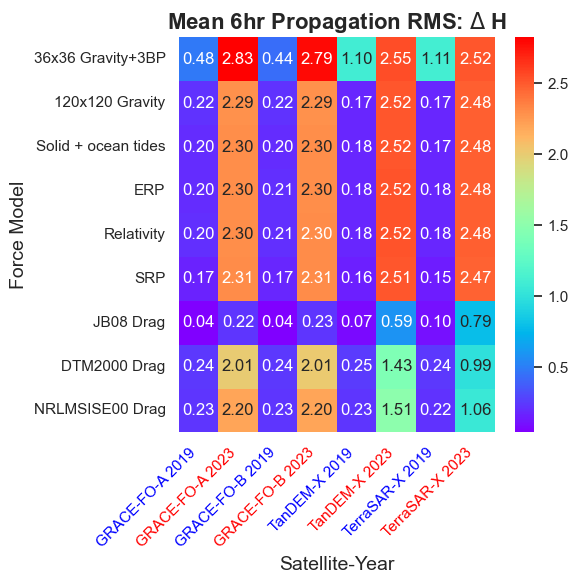

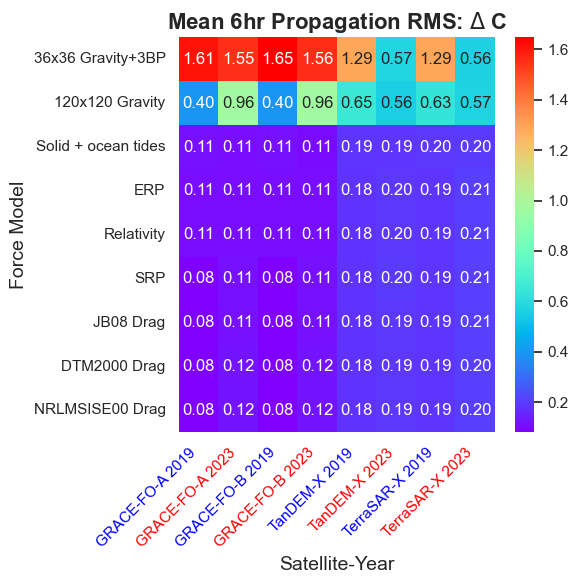

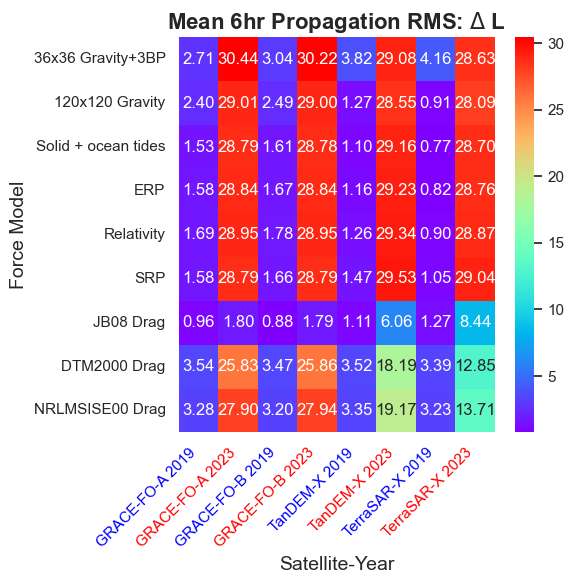

In [461]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

# Initialize seaborn theme
sns.set_theme()

# Define parameters
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]
components = ['H', 'C', 'L']

force_model_steps = [
    '36x36 Gravity+3BP',
    '120x120 Gravity',
    'Solid + ocean tides',
    'ERP',
    'Relativity',
    'SRP',
    'JB08 Drag',
    'DTM2000 Drag',
    'NRLMSISE00 Drag'
]

# Function to extract force model from configuration name
def extract_force_model(config_name):
    return re.sub(r'arc\d+_', '', config_name)

# Function to extract year from file path, converting 2019 to 2018
def extract_year(file_path):
    match = re.search(r'_(\d{4})-\d{2}-\d{2}', file_path)
    year = match.group(1) if match else None
    if year == '2018':
        year = '2019'  # Combine 2019 data with 2018
    return year

# Function to calculate RMS for all values in each configuration
def calculate_rms(values):
    # Flatten the list of lists to calculate the RMS across all diffs in a configuration
    flattened_values = [val for sublist in values for val in sublist]
    return np.sqrt(np.mean(np.square(flattened_values)))

# Initialize a dictionary to store RMS values for each component, force model, satellite, and year
rms_values = {}

# Populate rms_values
for component in components:
    rms_values[component] = {}
    for sat_name in sat_names_to_test:
        for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
            for file in files:
                if file.endswith("_hcl_diffs.npy"):
                    year = extract_year(os.path.join(root, file))
                    if year not in rms_values[component]:
                        rms_values[component][year] = {}
                    hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                    if component in hcl_diffs:
                        for config, diffs in hcl_diffs[component].items():
                            force_model = extract_force_model(config)
                            # Calculate RMS of all values for each configuration
                            config_rms = calculate_rms(diffs)
                            if force_model not in rms_values[component][year]:
                                rms_values[component][year][force_model] = {}
                            rms_values[component][year][force_model][sat_name] = config_rms
# Define the new column labels for the heatmap, representing each spacecraft-year combination
column_labels = [f"{sat} {year}" for sat in sat_names_to_test for year in sorted(rms_values[components[0]].keys())]

data_for_df = []

# Iterate through the rms_values to populate the data_for_df list
for component in rms_values:
    for year in rms_values[component]:
        for force_model in rms_values[component][year]:
            for sat_name in rms_values[component][year][force_model]:
                rms_value = rms_values[component][year][force_model][sat_name]
                # Append a new row for each RMS value
                data_for_df.append({
                    'Component': component,
                    'Year': year,
                    'Force Model': force_model,
                    'Satellite': sat_name,
                    'RMS': rms_value
                })

import pandas as pd

# Create DataFrame from the data
df = pd.DataFrame(data_for_df)

# Map verbose force model names to simplified labels
force_model_mapping = {
    "36x36gravity+3BP": "36x36 Gravity+3BP",
    "120x120gravity+3BP": "120x120 Gravity",
    "120x120gravity+3BP+solid_tides+ocean_tides": "Solid + ocean tides",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp": "ERP",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity": "Relativity",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP": "SRP",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP+jb08drag": "JB08 Drag",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP+dtm2000drag": "DTM2000 Drag",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP+nrlmsise00drag": "NRLMSISE00 Drag"
}
# Create DataFrame from the data
df = pd.DataFrame(data_for_df)

# Ensure force model names are mapped directly as they appear in force_model_steps
df['Force Model Simplified'] = df['Force Model'].apply(lambda x: force_model_mapping.get(x, x))

# Order the DataFrame based on the order of force_model_steps
force_model_order = {name: i for i, name in enumerate(force_model_steps)}
df['Order'] = df['Force Model Simplified'].map(force_model_order)

# Sort df by this order for plotting
df.sort_values(by=['Component', 'Order'], ascending=[True, True], inplace=True)

for component in components:
    df_filtered = df[df['Component'] == component].copy()

    df_filtered['Force Model Simplified'] = pd.Categorical(df_filtered['Force Model Simplified'], categories=force_model_steps, ordered=True)
    df_filtered['Satellite-Year'] = df_filtered['Satellite'] + ' ' + df_filtered['Year']
    df_filtered.sort_values(by='Force Model Simplified', inplace=True)

    heatmap_data = df_filtered.pivot_table(index='Force Model Simplified', columns='Satellite-Year', values='RMS', aggfunc='mean')

    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(heatmap_data, annot=True, cmap="rainbow", fmt=".2f")
    plt.title(f'Mean 6hr Propagation RMS: $\Delta$ {component}', fontsize=16, fontweight='bold')
    plt.ylabel('Force Model', fontsize=14)
    plt.xlabel('Satellite-Year', fontsize=14)

    # Change x-tick label colors based on year
    for label in ax.get_xticklabels():
        if "2019" in label.get_text():
            label.set_color('blue')
        elif "2023" in label.get_text():
            label.set_color('red')

    # Rotate the x labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

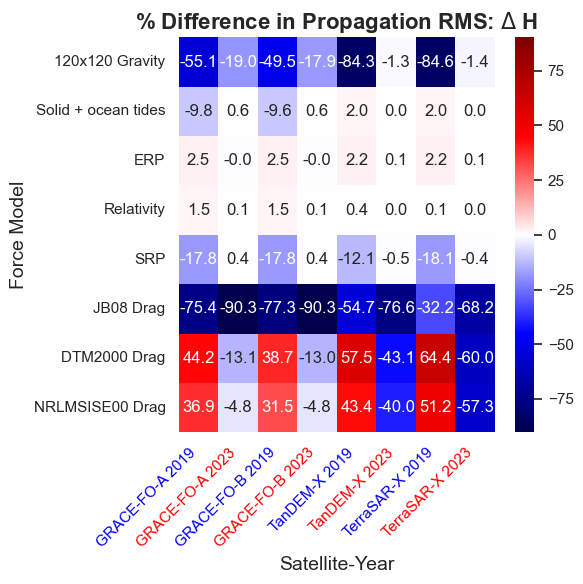

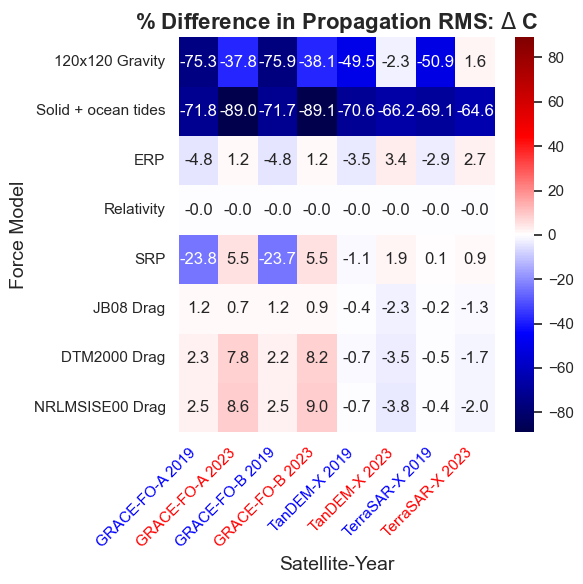

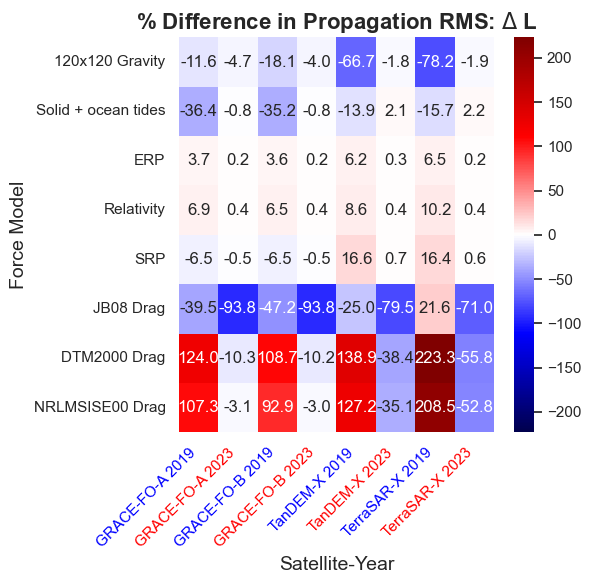

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

# Initialize seaborn theme
sns.set_theme()

# Define parameters
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]
components = ['H', 'C', 'L']

force_model_steps = [
    '36x36 Gravity+3BP',
    '120x120 Gravity',
    'Solid + ocean tides',
    'ERP',
    'Relativity',
    'SRP',
    'JB08 Drag',
    'DTM2000 Drag',
    'NRLMSISE00 Drag'
]

# Function to extract force model from configuration name
def extract_force_model(config_name):
    return re.sub(r'arc\d+_', '', config_name)

# Function to extract year from file path, converting 2019 to 2018
def extract_year(file_path):
    match = re.search(r'_(\d{4})-\d{2}-\d{2}', file_path)
    year = match.group(1) if match else None
    if year == '2018':
        year = '2019'  # Combine 2019 data with 2018
    return year

# Function to calculate RMS for all values in each configuration
def calculate_rms(values):
    # Flatten the list of lists to calculate the RMS across all diffs in a configuration
    flattened_values = [val for sublist in values for val in sublist]
    return np.sqrt(np.mean(np.square(flattened_values)))

# Initialize a dictionary to store RMS values for each component, force model, satellite, and year
rms_values = {}

# Populate rms_values
for component in components:
    rms_values[component] = {}
    for sat_name in sat_names_to_test:
        for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
            for file in files:
                if file.endswith("_hcl_diffs.npy"):
                    year = extract_year(os.path.join(root, file))
                    if year not in rms_values[component]:
                        rms_values[component][year] = {}
                    hcl_diffs = np.load(os.path.join(root, file), allow_pickle=True).item()
                    if component in hcl_diffs:
                        for config, diffs in hcl_diffs[component].items():
                            force_model = extract_force_model(config)
                            # Calculate RMS of all values for each configuration
                            config_rms = calculate_rms(diffs)
                            if force_model not in rms_values[component][year]:
                                rms_values[component][year][force_model] = {}
                            rms_values[component][year][force_model][sat_name] = config_rms
# Define the new column labels for the heatmap, representing each spacecraft-year combination
column_labels = [f"{sat} {year}" for sat in sat_names_to_test for year in sorted(rms_values[components[0]].keys())]

data_for_df = []

# Iterate through the rms_values to populate the data_for_df list
for component in rms_values:
    for year in rms_values[component]:
        for force_model in rms_values[component][year]:
            for sat_name in rms_values[component][year][force_model]:
                rms_value = rms_values[component][year][force_model][sat_name]
                # Append a new row for each RMS value
                data_for_df.append({
                    'Component': component,
                    'Year': year,
                    'Force Model': force_model,
                    'Satellite': sat_name,
                    'RMS': rms_value
                })

import pandas as pd

# Create DataFrame from the data
df = pd.DataFrame(data_for_df)

# Map verbose force model names to simplified labels
force_model_mapping = {
    "36x36gravity+3BP": "36x36 Gravity+3BP",
    "120x120gravity+3BP": "120x120 Gravity",
    "120x120gravity+3BP+solid_tides+ocean_tides": "Solid + ocean tides",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp": "ERP",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity": "Relativity",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP": "SRP",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP+jb08drag": "JB08 Drag",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP+dtm2000drag": "DTM2000 Drag",
    "120x120gravity+3BP+solid_tides+ocean_tides+knocke_erp+relativity+SRP+nrlmsise00drag": "NRLMSISE00 Drag"
}
# Create DataFrame from the data
df = pd.DataFrame(data_for_df)

# Ensure force model names are mapped directly as they appear in force_model_steps
df['Force Model Simplified'] = df['Force Model'].apply(lambda x: force_model_mapping.get(x, x))

# Order the DataFrame based on the order of force_model_steps
force_model_order = {name: i for i, name in enumerate(force_model_steps)}
df['Order'] = df['Force Model Simplified'].map(force_model_order)

# Sort df by this order for plotting
df.sort_values(by=['Component', 'Order'], ascending=[True, True], inplace=True)

def calculate_percentage_difference_adjusted(df, force_model_steps):
    df['Percentage Difference'] = np.nan  # Initialize column
    for component in df['Component'].unique():
        for sy in df['Satellite-Year'].unique():
            sub_df = df[(df['Component'] == component) & (df['Satellite-Year'] == sy)].copy()
            if len(sub_df) < len(force_model_steps):  # If there are fewer rows than force models, skip
                continue
            # Calculate percentage difference normally for all but the last three
            for i in range(len(force_model_steps) - 4):
                if sub_df.iloc[i]['Order'] + 1 == sub_df.iloc[i + 1]['Order']:  # Ensure consecutive order
                    diff = (sub_df.iloc[i + 1]['RMS'] - sub_df.iloc[i]['RMS']) / sub_df.iloc[i]['RMS'] * 100
                    df.loc[(df['Component'] == component) & (df['Satellite-Year'] == sy) & (df['Order'] == sub_df.iloc[i + 1]['Order']), 'Percentage Difference'] = diff
            # For the last three rows, compare against the 4th last entry
            base_rms = sub_df.iloc[-4]['RMS']  # 4th last RMS value
            for i in range(-3, 0):
                diff = (sub_df.iloc[i]['RMS'] - base_rms) / base_rms * 100
                df.loc[(df['Component'] == component) & (df['Satellite-Year'] == sy) & (df['Order'] == sub_df.iloc[i]['Order']), 'Percentage Difference'] = diff
    return df

# After creating the DataFrame and before calculating percentage differences
df['Satellite-Year'] = df['Satellite'] + ' ' + df['Year']

# Now, when you call calculate_percentage_difference, the 'Satellite-Year' column exists
df = calculate_percentage_difference_adjusted(df, force_model_steps)


# Drop the first occurrence of each group since their percentage difference is NaN
df.dropna(subset=['Percentage Difference'], inplace=True)


for component in components:
    df_filtered = df[df['Component'] == component].copy()

    df_filtered['Force Model Simplified'] = pd.Categorical(df_filtered['Force Model Simplified'], categories=force_model_steps, ordered=True)
    df_filtered['Satellite-Year'] = df_filtered['Satellite'] + ' ' + df_filtered['Year']
    df_filtered.sort_values(by='Force Model Simplified', inplace=True)

    heatmap_data = df_filtered.pivot_table(index='Force Model Simplified', columns='Satellite-Year', values='Percentage Difference', aggfunc='mean')

    # Calculate the maximum absolute percentage difference for the current component
    max_abs_percentage_diff = np.abs(heatmap_data.values).max()

    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(heatmap_data, annot=True, cmap="seismic", fmt=".1f",
                     vmin=-max_abs_percentage_diff, vmax=max_abs_percentage_diff, center=0)
    plt.title(f'% Difference in Propagation RMS: $\Delta$ {component}', fontsize=16, fontweight='bold')
    plt.ylabel('Force Model', fontsize=14)
    plt.xlabel('Satellite-Year', fontsize=14)

    # Change x-tick label colors based on year and rotate them
    for label in ax.get_xticklabels():
        if "2019" in label.get_text():
            label.set_color('blue')
        elif "2023" in label.get_text():
            label.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


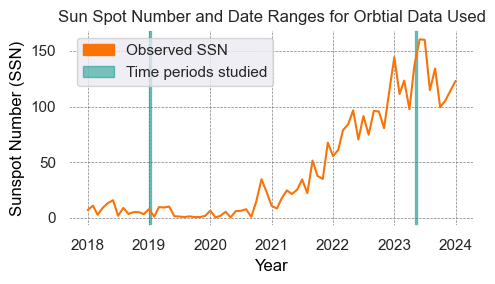

In [467]:

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# URLs to fetch data from
observed_data_url = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
predicted_data_url = "https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json"

# Fetching the data
observed_data_response = requests.get(observed_data_url)
predicted_data_response = requests.get(predicted_data_url)

#set matplotlib theme
plt.style.use('fast')

# Checking if the requests were successful
if observed_data_response.status_code == 200 and predicted_data_response.status_code == 200:
    observed_data = observed_data_response.json()
    predicted_data = predicted_data_response.json()
    
    # Convert JSON data into pandas DataFrames
    df_observed = pd.DataFrame(observed_data)
    df_predicted = pd.DataFrame(predicted_data)
    
    # Convert "time-tag" to datetime format
    df_observed['time-tag'] = pd.to_datetime(df_observed['time-tag'])
    df_predicted['time-tag'] = pd.to_datetime(df_predicted['time-tag'])
    
    df_observed_filtered = df_observed[(df_observed['time-tag'].dt.year >= 2018) & (df_observed['time-tag'].dt.year <= 2024)]
    
    # Plotting
    plt.figure(figsize=(5, 3))
    
    # Plot observed data
    plt.plot(df_observed_filtered['time-tag'], df_observed_filtered['ssn'], label='Observed SSN', color='xkcd:orange')

    # Highlight specific regions
    plt.axvspan(pd.Timestamp('2018-12-31'), pd.Timestamp('2019-01-10'), color='xkcd:teal', alpha=0.5, label='Dec 2018 - Jan 2019')
    plt.axvspan(pd.Timestamp('2023-05-04'), pd.Timestamp('2023-05-15'), color='xkcd:teal', alpha=0.5, label='May 2023')

    plt.title('Sun Spot Number and Date Ranges for Orbtial Data Used')
    plt.xlabel('Year', color='black')
    plt.ylabel('Sunspot Number (SSN)', color='black')

    # Creating custom patches as legend handles
    observed_patch = mpatches.Patch(color='xkcd:orange', label='Observed SSN')
    highlight_patch = mpatches.Patch(color='xkcd:teal', alpha=0.5, label='Time periods studied')

    plt.legend(handles=[observed_patch, highlight_patch], loc='upper left')
    plt.gca().set_facecolor('white')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to fetch data")

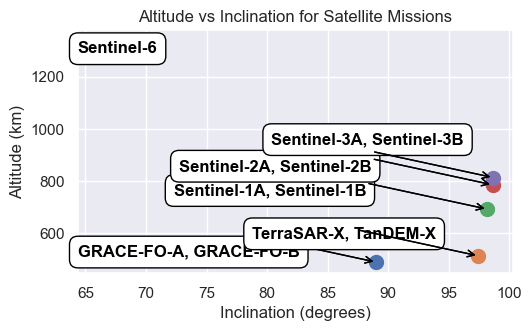

In [367]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

mission_data = {
    "GRACE-FO-A": {"Inclination": 89.0, "Altitude": 490},
    "GRACE-FO-B": {"Inclination": 89.0, "Altitude": 490},
    "TerraSAR-X": {"Inclination": 97.44, "Altitude": 514},
    "TanDEM-X": {"Inclination": 97.44, "Altitude": 514},
    "Sentinel-1A": {"Inclination": 98.18, "Altitude": 693},
    "Sentinel-1B": {"Inclination": 98.18, "Altitude": 693},
    "Sentinel-2A": {"Inclination": 98.62, "Altitude": 786},
    "Sentinel-2B": {"Inclination": 98.62, "Altitude": 786},
    "Sentinel-3A": {"Inclination": 98.65, "Altitude": 814},
    "Sentinel-3B": {"Inclination": 98.65, "Altitude": 814},
    "Sentinel-6": {"Inclination": 66, "Altitude": 1336},
}

plt.figure(figsize=(5, 3))

# Group missions by (Inclination, Altitude)
grouped_missions = {}
texts = []  # Store text objects for adjust_text

for mission, data in mission_data.items():
    key = (data["Inclination"], data["Altitude"])
    if key not in grouped_missions:
        grouped_missions[key] = []
    grouped_missions[key].append(mission)

# Plot and label
for (inclination, altitude), missions in grouped_missions.items():
    plt.scatter(inclination, altitude, s=100)
    if len(missions) > 1:
        label = ", ".join(missions)
        text_x = inclination - 10
        text_y = altitude + len(missions) * 50
        text = plt.text(text_x, text_y, label, fontsize=12, ha='right', color='black', fontweight='bold',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        texts.append(text)
        for mission in missions:
            plt.annotate('', xy=(inclination, altitude), xytext=(text_x, text_y),
                         arrowprops=dict(arrowstyle="->",color='black', connectionstyle="arc3"))
    else:
        text = plt.text(inclination, altitude, missions[0], fontsize=12, ha='right', color='black', fontweight='bold',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        texts.append(text)

plt.xlabel("Inclination (degrees)")
plt.ylabel("Altitude (km)")
plt.title("Altitude vs Inclination for Satellite Missions")
plt.grid(True)

# Use adjust_text to automatically adjust the text positions
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

plt.show()
